# Text Summarization using Encoder-Decoder

## Import Libraries

In [1]:
import re
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.compat.v1 import ConfigProto, InteractiveSession
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Import Dataset

In [2]:
classes = os.listdir('../input/bbc-news-summary/BBC News Summary/News Articles')
Articles_dir = '../input/bbc-news-summary/BBC News Summary/News Articles/'
Summaries_dir = '../input/bbc-news-summary/BBC News Summary/Summaries/'

articles = []
summaries = []
file_arr = []
for cls in classes:
    files = os.listdir(Articles_dir + cls)
    for file in files:
        article_file_path = Articles_dir + cls + '/' + file
        summary_file_path = Summaries_dir + cls + '/' + file
        try:
            with open (article_file_path,'r') as f:
                articles.append('.'.join([line.rstrip() for line in f.readlines()]))
            with open (summary_file_path,'r') as f:
                summaries.append('.'.join([line.rstrip() for line in f.readlines()]))
            file_arr.append(cls + '/' + file)
        except:
            pass
            
dataset = pd.DataFrame({'File_path':file_arr,'Articles': articles,'Summaries':summaries})
# dataset['Articles'][0]
dataset.head()

,File_path,Articles,Summaries
0,politics/361.txt,Budget to set scene for election..Gordon Brown...,- Increase in the stamp duty threshold from £6...
1,politics/245.txt,Army chiefs in regiments decision..Military ch...,"""They are very much not for the good and will ..."
2,politics/141.txt,Howard denies split over ID cards..Michael How...,Michael Howard has denied his shadow cabinet w...
3,politics/372.txt,Observers to monitor UK election..Ministers wi...,The report said individual registration should...
4,politics/333.txt,Kilroy names election seat target..Ex-chat sho...,"UKIP's leader, Roger Knapman, has said he is g..."


## Expanding Contractions
 
Contractions are shortened version of words or syllables. They often exist in either written or spoken forms in the English language. These shortened versions or contractions of words are created by removing specific letters and sounds. In case of English contractions, they are often created by removing one of the vowels from the word. Examples would be, do not to don’t and I would to I’d. Converting each contraction to its expanded, original form helps with text standardization.

In [3]:
contractions_dictionary = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

## Text Preprocessing

In [4]:
from string import digits
import re

def Filter(text):
#     pattern = r'[0-9]'

# # Match all digits in the string and replace them with an empty string
#     text = re.sub(pattern, '', text)
#     remove_digits = str.maketrans('', '', digits)
#     text = text.translate(remove_digits)
    text=text.lower()
    text=' '.join([contractions_dictionary[i] if i in contractions_dictionary.keys() else i for i in text.split()])
    text=re.sub(r'\(.*\)',"",text)
    text=re.sub("'s","",text)
    text=re.sub('"','',text)
    text=' '.join([i for i in text.split() if i.isalpha()])
    text=re.sub('[^a-zA-Z]'," ",text)
    
    return text

dataset['File_path'] = dataset['File_path'].apply(Filter)
dataset['Articles'] = dataset['Articles'].apply(Filter)
dataset['Summaries'] = dataset['Summaries'].apply(Filter)

In [5]:
print(dataset.shape)
dataset.head()

(2224, 3)


,File_path,Articles,Summaries
0,,budget to set scene for brown will seek to put...,increase in the stamp duty threshold from a fr...
1,,army chiefs in regiments chiefs are expected t...,they are very much not for the good and will d...
2,,howard denies split over id howard has denied ...,michael howard has denied his shadow cabinet w...
3,,observers to monitor uk will invite internatio...,the report said individual registration should...
4,,kilroy names election seat show host robert is...,ukip roger has said he is glad to see the back...


## Tonkenization

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 3000
embedding_dim = 100
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 2000

articles_tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
articles_tokenizer.fit_on_texts(dataset['Articles'])

summaries_tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
summaries_tokenizer.fit_on_texts(dataset['Summaries'])

# word_index = tokenizer.word_index

training_sequences = articles_tokenizer.texts_to_sequences(dataset['Articles'])
training_x_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_sequences = summaries_tokenizer.texts_to_sequences(dataset['Summaries'])
training_y_padded = pad_sequences(training_sequences, maxlen=30, padding=padding_type, truncating=trunc_type)



In [7]:
training_x_padded.shape

(2224, 100)

In [8]:
NUM_TRAIN = 2224
article_map = dict(map(reversed, articles_tokenizer.word_index.items()))
summaries_map = dict(map(reversed, summaries_tokenizer.word_index.items()))

article = np.zeros((NUM_TRAIN,100,vocab_size))
summ = np.zeros((NUM_TRAIN,30,vocab_size))
summ_target = np.zeros((NUM_TRAIN,30,vocab_size))
for i,sequence in enumerate(training_x_padded):
    for j,word in enumerate(sequence):
        article[i,j,word ] = 1
        
for i,sequence in enumerate(training_y_padded):
    for j,word in enumerate(sequence):
        summ[i,j,word] = 1
        if j>0:
            summ_target[i,j-1,word] = 1


In [9]:
training_x = article
training_y = summ
training_y_target = summ_target
# testing_x_padded = np.array(testing_x_padded)
# testing_y_padded = np.array(testing_y_padded)

print(training_x.shape)
print(training_y.shape)
print(training_y_target.shape)
# print(testing_x_padded.shape)
# print(testing_y_padded.shape)

(2224, 100, 3000)
(2224, 30, 3000)
(2224, 30, 3000)


## Creating Model

You have two set of LSTMs (green and blue below). Each set respectively sharing weights (i.e. each of the 4 green cells have the same weights and similarly with the blue cells). The first is a many to one LSTM, which summarises the question at the last hidden layer/ cell memory.

The second set (blue) is a Many to Many LSTM which has different weights to the first set of LSTMs. The input is simply the answer sentence while the output is the same sentence shifted by one.

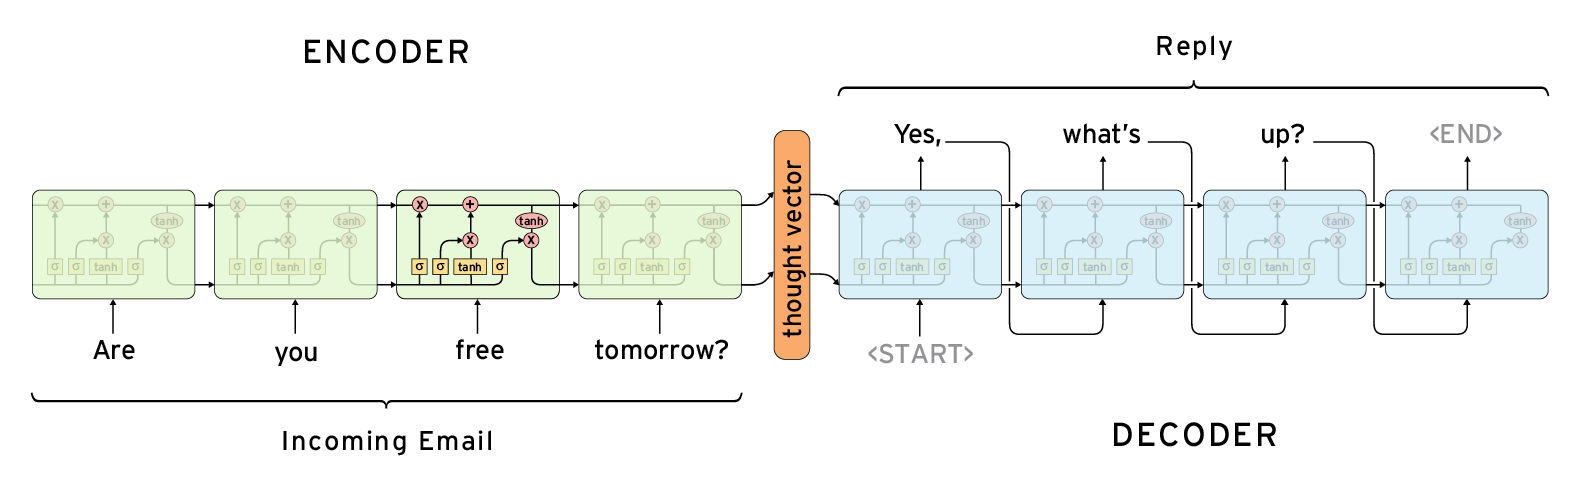


In [10]:
encoder_inputs = tf.keras.layers.Input(shape=(None, vocab_size))
encoder = tf.keras.layers.LSTM(embedding_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]


decoder_inputs = tf.keras.layers.Input(shape=(None, vocab_size))
decoder_lstm = tf.keras.layers.LSTM(embedding_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 3000)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, None, 3000)  0           []                               
                                ]                                                                 
                                                                                                  
 lstm (LSTM)                    [(None, 100),        1240400     ['input_1[0][0]']                
                                 (None, 100),                                                 

In [11]:

model.fit([training_x,training_y],training_y_target,
          epochs=2000,
          batch_size=64,
          callbacks = [tf.keras.callbacks.CSVLogger('./training.csv')]
          )

Epoch 1/2000
35/35 [==============================] - 17s 99ms/step - loss: 7.0674 - accuracy: 0.0967
Epoch 2/2000
35/35 [==============================] - 4s 104ms/step - loss: 5.7334 - accuracy: 0.1084
Epoch 3/2000
35/35 [==============================] - 4s 106ms/step - loss: 5.6975 - accuracy: 0.1084
Epoch 4/2000
35/35 [==============================] - 4s 101ms/step - loss: 5.6924 - accuracy: 0.1084
Epoch 5/2000
35/35 [==============================] - 4s 102ms/step - loss: 5.6892 - accuracy: 0.1084
Epoch 6/2000
35/35 [==============================] - 4s 119ms/step - loss: 5.6854 - accuracy: 0.1084
Epoch 7/2000
35/35 [==============================] - 4s 106ms/step - loss: 5.6818 - accuracy: 0.1084
Epoch 8/2000
35/35 [==============================] - 4s 101ms/step - loss: 5.6778 - accuracy: 0.1084
Epoch 9/2000
35/35 [==============================] - 4s 107ms/step - loss: 5.6733 - accuracy: 0.1084
Epoch 10/2000
35/35 [==============================] - 4s 101ms/step - loss: 5.666

In [12]:
model.save('model.h5')

model.save_weights('./my_checkpoint')


encoder_model = tf.keras.Model(encoder_inputs, encoder_states)
decoder_state_input_h = tf.keras.layers.Input(shape=(embedding_dim,))
decoder_state_input_c = tf.keras.layers.Input(shape=(embedding_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

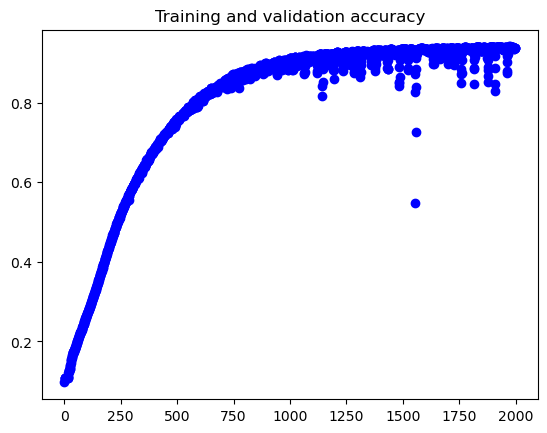

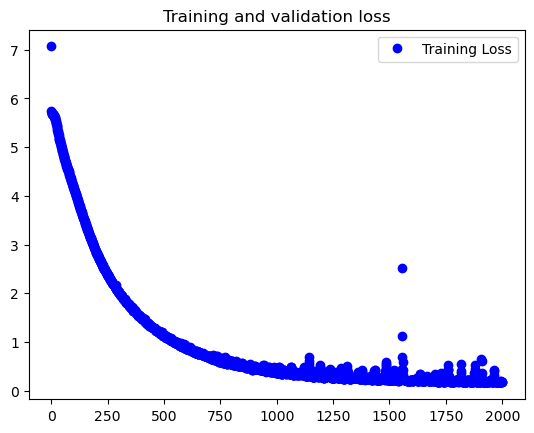

In [13]:
## Visualising the Accuracy and loss plots

callback_csv = pd.read_csv('./training.csv')
acc = callback_csv['accuracy']
loss = callback_csv['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')

plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')

plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:

#Define Decode Sequence
def decode_sequence(input_seq):
    #Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    #Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 3000))
    #Get the first character of target sequence with the start character.
    target_seq[0, 0, summaries_tokenizer.word_index['<OOV>']] = 1.

    #Sampling loop for a batch of sequences
    #(to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        #Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = summaries_map[sampled_token_index]
        decoded_sentence += ' '+ sampled_char
        
        #Exit condition: either hit max length
        #or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > 70):
            stop_condition = True

        #Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 3000))
        target_seq[0, 0, sampled_token_index] = 1.

        #Update states
        states_value = [h, c]

    return decoded_sentence

In [15]:
for seq_index in range(10):
    input_seq = training_x[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', dataset['Articles'][seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 [==============================] - 0s 25ms/step
-
Input sentence: budget to set scene for brown will seek to put the economy at the centre of labour bid for a third term in power when he delivers his ninth budget at he is expected to stress the importance of continued economic with low unemployment and interest the chancellor is expected to freeze petrol duty and raise the stamp duty threshold from but the conservatives and lib dems insist voters face higher taxes and more under officials have said there will not be a but mr brown is thought to have about to increase in the stamp duty threshold from a freeze on petrol an extension of tax credit scheme for poorer possible help for pensioners the stamp duty threshold rise is intended to help first time buyers a likely theme of all three of the main general election ten years buyers had a much greater chance of avoiding stamp with close to half a million in england and wales selling for less than since average uk property prices have 

In [16]:
encoder_model.save('encoder.h5')
decoder_model.save('decoder.h5')